# All cells
## Xiaonan Wang
## 03Oct2019

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns

cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.3.7 anndata==0.6.16 numpy==1.16.3 scipy==1.2.1 pandas==0.23.1 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
plt.rcParams["figure.figsize"] = (5,4.5)

In [3]:
def expPlotFun(adata, group = 'Study', color='louvain_rd10', vmin=None, vmax=None, size=50):
    if vmax is None:
        if color in adata.raw.var_names:
            vmax = np.max(adata.raw[:,color].X)
    if vmin is None:
        vmin = 0
        
    gs = adata.obs[group].cat.categories
    
    ng = len(gs)+1
    fig,ax = plt.subplots(1,ng, figsize=(5*ng,4.5), sharex=True, sharey=True)
    
    ax1=sc.pl.umap(adata ,ax=ax[0], legend_loc="on data", color=color, show=False, size=size, color_map=cmap, vmin=vmin, vmax=vmax, legend_fontsize=15)
    for i in range(len(gs)):
        ax2=sc.pl.umap(adata[adata.obs[group]==gs[i],:], title=gs[i],ax=ax[i+1], legend_loc="on data", vmin=vmin, vmax=vmax, color=color, show=False, size=size, color_map=cmap, legend_fontsize=15)
    fig.tight_layout()

In [51]:
def barplot_fun(adata, con1, con2, plot=True):
    t1 = pd.crosstab(adata.obs[con1], adata.obs[con2],dropna =False)
    t1 = t1.div(t1.sum(axis=0),axis=1)*10000
    t1_per = t1.div(t1.sum(axis=1),axis=0)*100
    
    if (plot==True):
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
        t1.plot.bar(edgecolor="black", ax=ax[0])
        ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        ax[0].set_ylabel('normalised # of cells')
        ax[0].grid()
        t1_per.plot.bar(stacked=True, edgecolor="black", ax=ax[1])
        ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        ax[1].set_ylabel('% in each cluster')
        ax[1].grid()
        fig.tight_layout()
    return t1_per

## Read in Counts

In [4]:
path = '/servers/lila-single-cell/Xiaonan/Zebrafish/NewData/181011_K00198_0353_BH2GVLBBXY/REX/WTCHG_587680_45/outs/raw_gene_bc_matrices/GRCz11/'
adata45 = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata45.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata45.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata45.var_names_make_unique()
adata45.obs['Study'] = ["WT"]*len(adata45.obs_names)
path = '/servers/lila-single-cell/Xiaonan/Zebrafish/NewData/181011_K00198_0353_BH2GVLBBXY/REX/WTCHG_587680_46/outs/raw_gene_bc_matrices/GRCz11/'
adata46 = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata46.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata46.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata46.var_names_make_unique()
adata46.obs['Study'] = ["Injured"]*len(adata46.obs_names)
path = '/servers/lila-single-cell/Xiaonan/Zebrafish/NewData/181011_K00198_0353_BH2GVLBBXY/REX/WTCHG_587680_47/outs/raw_gene_bc_matrices/GRCz11/'
adata47 = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
adata47.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
adata47.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata47.var_names_make_unique()
adata47.obs['Study'] = ["Injured_Runx1_KO"]*len(adata47.obs_names)

... writing an h5ad cache file to speedup reading next time


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... writing an h5ad cache file to speedup reading next time


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... writing an h5ad cache file to speedup reading next time


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata = adata45.concatenate(adata46, adata47)
print(adata.shape)

(2211840, 26977)


In [6]:
adata.obs['Study'] = adata.obs['Study'].astype('category')
adata.obs['Study'] = adata.obs['Study'].cat.reorder_categories(['WT', 'Injured', 'Injured_Runx1_KO'])

In [7]:
adata.obs['n_genes_total'] = np.sum(adata.X>0, axis=1)
adata.obs['n_counts_total'] = adata.X.sum(axis=1).A1

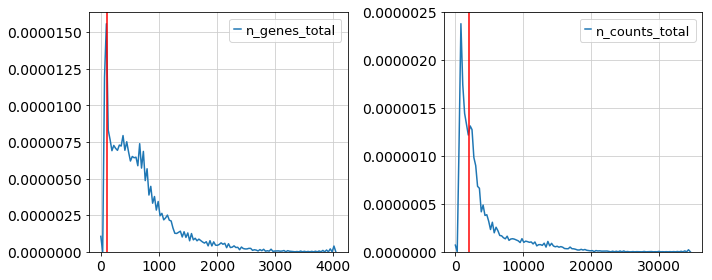

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.kdeplot(adata.obs['n_genes_total'],bw = 0.05, ax=ax[0])
ax[0].axvline(x=100, color='red')
sns.kdeplot(adata.obs['n_counts_total'],bw =0.05, ax=ax[1])
ax=ax[1].axvline(x=2000, color='red')
plt.tight_layout()

In [9]:
sc.pp.filter_cells(adata, min_genes=100)
print(adata.shape)

filtered out 2196098 cells that have less than 100 genes expressed
(15742, 26977)


In [10]:
adata.obs['Study'].value_counts()

Injured_Runx1_KO    6268
Injured             4754
WT                  4720
Name: Study, dtype: int64

## Doublet Removal

The code here will not run as scrublet involves random sampling. Thus, the results will be similar but not the same as what we used.

In [ ]:
# import scrublet as scr
# db_scores = []
# predicted_db = []
# Study_unique = ['WT', 'Injured', 'Injured_Runx1_KO']
# Cell_index = np.array([])
# for i in Study_unique:
#     scrub = scr.Scrublet(adata[adata.obs['Study']==i,:].X)
#     doublet_scores, predicted_doublets = scrub.scrub_doublets()
#     db_scores.append(doublet_scores)
#     predicted_db.append(predicted_doublets)
#     Cell_index = np.append(Cell_index, adata[adata.obs['Study']==i,:].obs_names)
    
# db_scores_all = np.concatenate(db_scores)
# adata = adata[Cell_index,:]
# adata.obs['doublet_scores'] = db_scores_all

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
# thres = [0.3, 0.27, 0.38]
# for i in range(len(Study_unique)):
#     pd.DataFrame(db_scores[i]).plot.hist(bins=100, ax=ax[i])
#     ax[i].axvline(x=thres[i], color='b')
#     ax[i].set_title(Study_unique[i])
#     ax[i].get_legend().remove()
# plt.tight_layout()

# Cells_passed = np.array([])
# for i in range(len(Study_unique)):
#     newD = adata[adata.obs['Study']==Study_unique[i],:].obs_names
#     cells = newD[db_scores[i] < thres[i]]
#     print(Study_unique[i]+':'+str(len(cells)))
#     Cells_passed = np.append(Cells_passed, cells)

In [11]:
# read in the previous saved scrublet results.
Cells_passed = np.genfromtxt('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis1/passed_CN.txt', dtype=str)

In [12]:
adata = adata[Cells_passed, :]

In [13]:
print(adata.shape)

(15415, 26977)


In [14]:
adata.obs['Study'].value_counts()

Injured_Runx1_KO    6054
Injured             4696
WT                  4665
Name: Study, dtype: int64

## Further QC

In [15]:
sc.pp.filter_genes(adata, min_counts=1)

filtered out 6152 genes that are detected in less than 1 counts


In [16]:
print(adata.shape)

(15415, 20825)


In [17]:
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

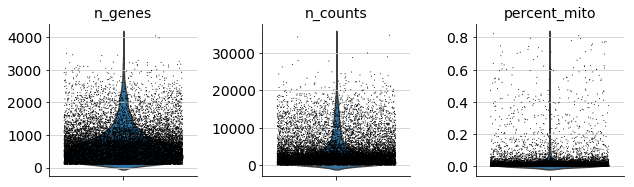

In [18]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Temporarily store the raw data as this is needed for quatifying marker genes.

In [19]:
adata.raw = sc.pp.log1p(adata, copy=True)

## Find highly variable genes

In [20]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)

4663


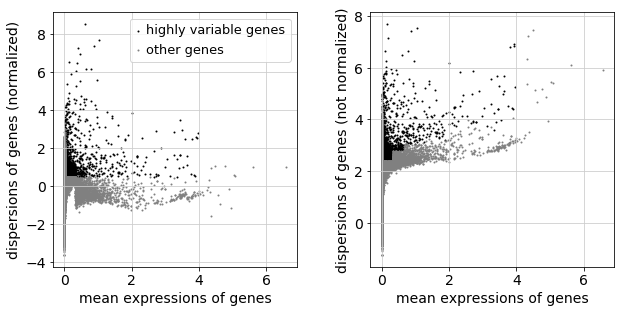

In [21]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=4, min_disp=0.5)
print(sum(filter_result.gene_subset))
sc.pl.filter_genes_dispersion(filter_result)

In [22]:
adata = adata[:, filter_result.gene_subset]

In [23]:
sc.pp.log1p(adata)

In [24]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:01:45.80)


In [25]:
sc.pp.scale(adata)

## Add in the vector information

The raw reads were aligned with the annotation with vector information involved and the vector informaiton was extracted

In [26]:
path = '/servers/lila-single-cell/Xiaonan/Zebrafish/NewData/Cellranger_run1/587680_45-REX/outs/raw_gene_bc_matrices/Zebrafish_mCherry_Citrine/'
markerD45 = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
markerD45.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
markerD45.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
markerD45.var_names_make_unique()
path = '/servers/lila-single-cell/Xiaonan/Zebrafish/NewData/Cellranger_run1/587680_46-REX/outs/raw_gene_bc_matrices/Zebrafish_mCherry_Citrine/'
markerD46 = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
markerD46.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
markerD46.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
markerD46.var_names_make_unique()
path = '/servers/lila-single-cell/Xiaonan/Zebrafish/NewData/Cellranger_run1/587680_47-REX/outs/raw_gene_bc_matrices/Zebrafish_mCherry_Citrine/'
markerD47 = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
markerD47.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
markerD47.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
markerD47.var_names_make_unique()

... writing an h5ad cache file to speedup reading next time


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... writing an h5ad cache file to speedup reading next time


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... writing an h5ad cache file to speedup reading next time


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [27]:
markerD = markerD45.concatenate(markerD46, markerD47)
marker_index = [x for x in markerD.var_names if 'mCherry' in x or 'Citrine' in x ]
markerD = markerD[:, marker_index]
print(markerD.X.shape)
print(markerD.var_names)

(2211840, 10)
Index(['mCherry', 'mCherry-plasmid-backbone', 'mCherry-polyA',
       'Citrine-3x-HA-tag', 'Citrine-BirA', 'Citrine-TaV-2a', 'Citrine',
       'Citrine-polyA', 'Citrine-Frt1', 'Citrine-Remaining'],
      dtype='object')


In [28]:
mchr = markerD[markerD[:,'mCherry'].X>0,:].obs_names
mchr_pb = markerD[markerD[:,'mCherry-plasmid-backbone'].X>0,:].obs_names
mchr_pa = markerD[markerD[:,'mCherry-polyA'].X>0,:].obs_names
cit = markerD[markerD[:,'Citrine'].X>0,:].obs_names
cit_pa = markerD[markerD[:,'Citrine-polyA'].X>0,:].obs_names
cit_pb = markerD[markerD[:,'Citrine-Remaining'].X>0,:].obs_names

In [29]:
mchr_overlap = reduce(np.union1d, (mchr,mchr_pb,mchr_pa))
cit_overlap = reduce(np.union1d, (cit,cit_pa,cit_pb))
print('mCherry cells: ', str(len(mchr_overlap)))
print('Citrine cells: ', str(len(cit_overlap)))

mCherry cells:  3915
Citrine cells:  6995


Now we define cit, mChr, cit_mChr, kdrl, runx1, kdrl_mchr, runx1_cit and eventually DBpos cells.

In [30]:
adata.obs['cit'] = np.in1d(adata.obs_names, cit_overlap)*1
adata.obs['mChr'] = np.in1d(adata.obs_names, mchr_overlap)*1
adata.obs['cit_mChr'] = np.in1d(adata.obs_names, np.intersect1d(cit_overlap, mchr_overlap))*1
adata.obs['kdrl_exp'] = (adata.raw[:,'kdrl'].X > 0)*1
adata.obs['runx1_exp'] = (adata.raw[:,'runx1'].X > 0)*1
adata.obs['kdrl_mchr'] = ((adata.obs['kdrl_exp']==1) | (adata.obs['mChr']==1))*1
adata.obs['runx1_cit'] = ((adata.obs['runx1_exp']==1) | (adata.obs['cit']==1))*1
adata.obs['DBpos'] = ((adata.obs['kdrl_mchr']==1) & (adata.obs['runx1_cit']==1))*1

In [31]:
print(adata.obs_keys())

['Study', 'batch', 'n_genes_total', 'n_counts_total', 'n_genes', 'percent_mito', 'n_counts', 'cit', 'mChr', 'cit_mChr', 'kdrl_exp', 'runx1_exp', 'kdrl_mchr', 'runx1_cit', 'DBpos']


In [32]:
keys2change = adata.obs_keys()[7:16]

In [33]:
print(keys2change)

['cit', 'mChr', 'cit_mChr', 'kdrl_exp', 'runx1_exp', 'kdrl_mchr', 'runx1_cit', 'DBpos']


In [34]:
for i in keys2change:
    if 'DBpos' in i:
        newK = ['Double+', 'Double-']
    else:
        newK = [i+'+', i+'-']
    newObs = [newK[0] if x==1 else newK[1] for x in adata.obs[i]]
    adata.obs[i] = newObs
    print(adata.obs[i].value_counts())
    adata.obs[i] = adata.obs[i].astype('category')

cit-    10121
cit+     5294
Name: cit, dtype: int64
mChr-    12212
mChr+     3203
Name: mChr, dtype: int64
cit_mChr-    14995
cit_mChr+      420
Name: cit_mChr, dtype: int64
kdrl_exp-    13651
kdrl_exp+     1764
Name: kdrl_exp, dtype: int64
runx1_exp-    15333
runx1_exp+       82
Name: runx1_exp, dtype: int64
kdrl_mchr-    11550
kdrl_mchr+     3865
Name: kdrl_mchr, dtype: int64
runx1_cit-    10097
runx1_cit+     5318
Name: runx1_cit, dtype: int64
Double-    14854
Double+      561
Name: DBpos, dtype: int64


## Dimensionality Reduction

In [36]:
sc.tl.pca(adata)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


In [ ]:
#np.savetxt('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/PCA_co_all.txt', adata.obsm['X_pca'], delimiter='\t')

In [37]:
adata.obsm['X_pca'] = np.genfromtxt('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/PCA_co_all.txt', delimiter='\t')

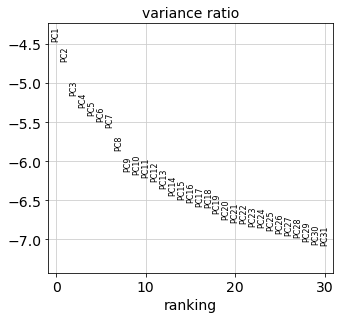

In [38]:
sc.pl.pca_variance_ratio(adata, log=True)

In [39]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:03:54.00) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [40]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:23.25) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [41]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:30.12) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [ ]:
#np.savetxt('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/UMAP_co_all.txt', adata.obsm['X_umap'], delimiter='\t')

In [42]:
adata.obsm['X_umap'] = np.genfromtxt('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/UMAP_co_all.txt', delimiter='\t')

In [43]:
sc.tl.draw_graph(adata, maxiter=100)

drawing single-cell graph using layout "fa"
    finished (0:00:52.61) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


## Louvain clustering

In [44]:
sc.tl.louvain(adata, resolution = 1, random_state=0,key_added='louvain_rd10')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:03.81) --> found 27 clusters and added
    'louvain_rd10', the cluster labels (adata.obs, categorical)


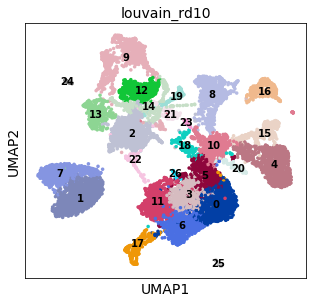

In [45]:
sc.pl.umap(adata, color=['louvain_rd10'], legend_loc="on data", size=50, color_map=cmap)

In [46]:
Lold = adata.obs['louvain_rd10'].astype('category')
Lold_lv = Lold.cat.categories
print(Lold_lv)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26'],
      dtype='object')


In [47]:
Lnew_lv = ['3', '25', '19', '2', '8', '4', '1', '24', '15', '23', '7', '0', '17',
       '22', '21', '10', '13', '11', '26', '14', '5', '18', '20', '12', '16',
       '9', '6']
adata.obs['louvain_rd10'] = Lold.cat.rename_categories(Lnew_lv)
adata.obs['louvain_rd10'] = adata.obs['louvain_rd10'].cat.reorder_categories(Lold_lv)

In [48]:
lv = ['0', '1', '2', '3', '4', '5', '6', 
      '7', '8', '9', '10', 
      '11', 
      '12','13',
      '14', '15','16', 
      '17', '18', 
      '19', '20', '21', '22', '23', 
      '24','25', 
      '26'
]

In [49]:
adata.uns['louvain_rd10_colors'] = [
    '#0B5345', '#15AB0F', '#63D95E', '#1D8348','#4BB80C', '#52BE80', '#1EF861', 
    '#D4E95E', '#8CA11C', '#7B8003', '#444604',
    '#5175FB', 
    '#58DDF5', '#2190A4', 
    '#A42DE9', '#7015EB', '#ABB7FF',
    '#F22BA2', '#EC7DBF',
    '#CC3D6E', '#FCC176', '#FFADAB', '#A93226', '#FD1901',
    '#FF5733', '#ff9900',
    '#C0C0C0'    
]

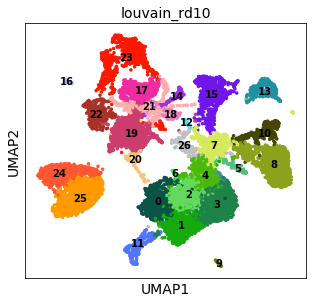

In [50]:
sc.pl.umap(adata, color='louvain_rd10', legend_loc="on data", size=50, color_map=cmap)

## Further analysis

Calculate proportion of each cluster in each sample.

Study,WT,Injured,Injured_Runx1_KO
louvain_rd10,,,
0,0.983697,56.189176,42.827127
1,31.844951,51.926332,16.228717
2,5.453338,24.805706,69.740956
3,86.435249,11.683766,1.880985
4,53.486536,18.421268,28.092196
5,24.344861,38.136547,37.518592
6,64.033653,6.361094,29.605252
7,22.630508,47.238801,30.130691
8,5.004331,45.294027,49.701642


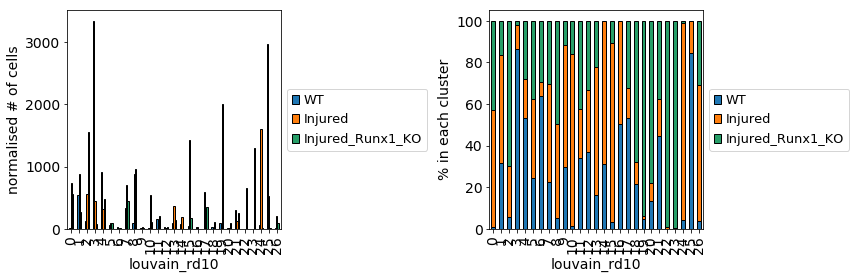

In [52]:
barplot_fun(adata, 'louvain_rd10', 'Study')

In [53]:
adata.write('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/write/Final_allcells_raw_afterQC.h5ad')

## Further plots

Change the raw data back to normalised data.

In [55]:
adata = sc.read('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/write/Final_allcells_raw_afterQC.h5ad')

In [56]:
import anndata
adata_nor = anndata.AnnData(X=np.exp(adata.raw.X.toarray())-1, var=adata.raw.var, obs=adata.obs)
sc.pp.normalize_per_cell(adata_nor, counts_per_cell_after=1e4)
adata.raw = sc.pp.log1p(adata_nor, copy=True)

Separated by samples.

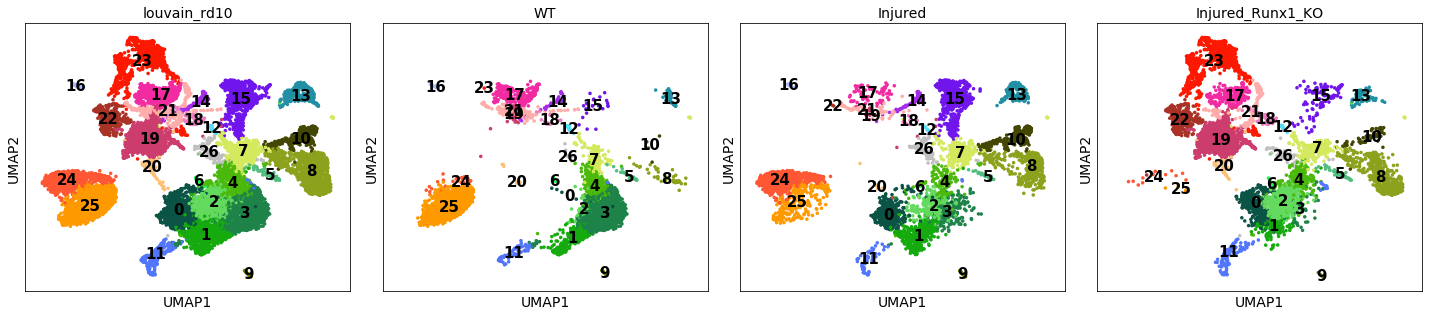

In [57]:
expPlotFun(adata, group='Study', color='louvain_rd10')

Separated by kdrl/mchr.

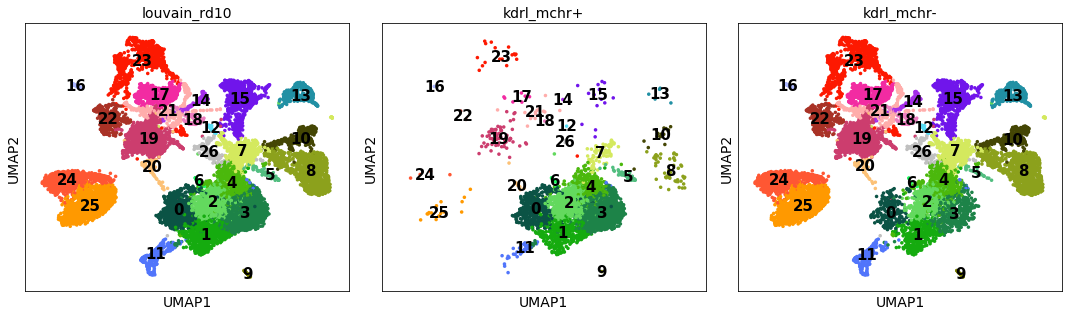

In [58]:
expPlotFun(adata, group='kdrl_mchr', color='louvain_rd10')

Separated by runx1/cit.

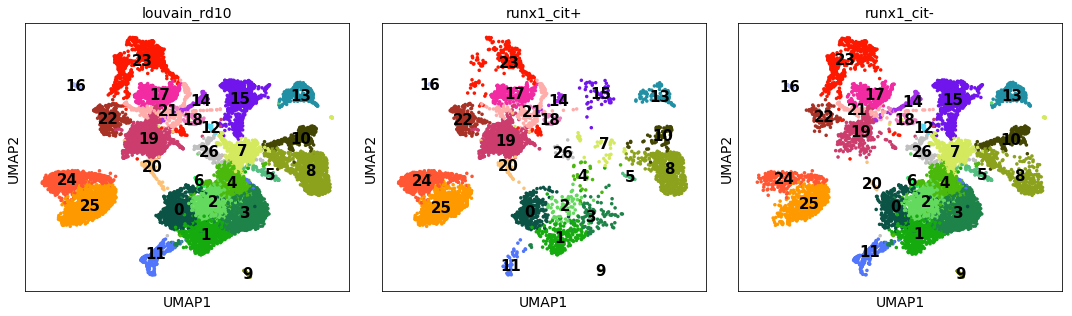

In [59]:
expPlotFun(adata, group='runx1_cit', color='louvain_rd10')

Separated by DBpos.

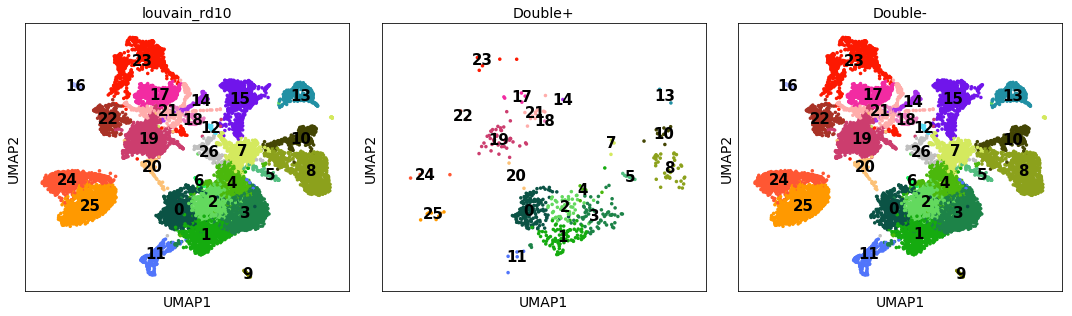

In [60]:
expPlotFun(adata, group='DBpos', color='louvain_rd10')

Key gene expression.

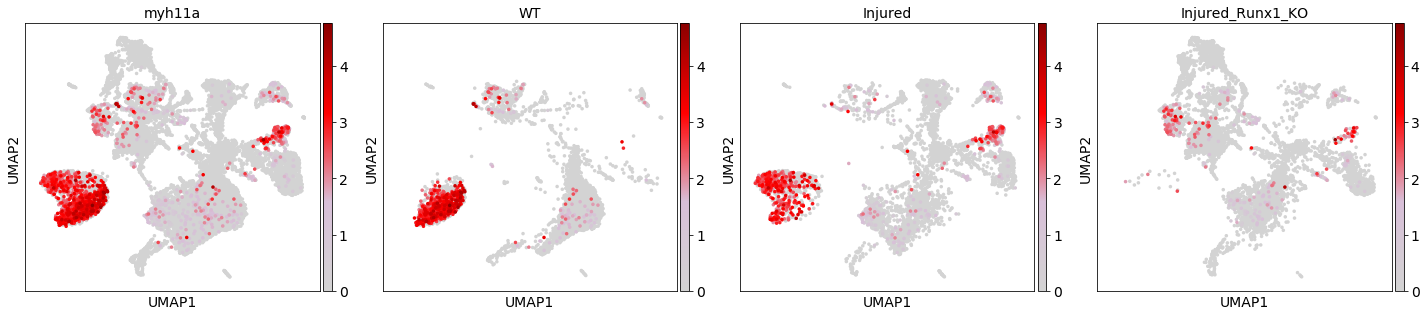

In [61]:
expPlotFun(adata, group='Study', color='myh11a')

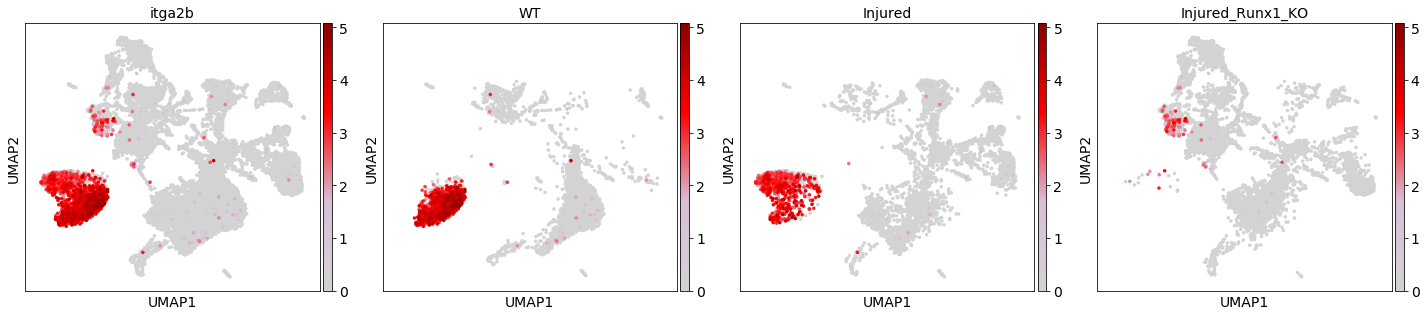

In [62]:
expPlotFun(adata, group='Study', color='itga2b')

## Find Marker Genes

In [63]:
sc.tl.rank_genes_groups(adata, 'louvain_rd10', n_genes=adata.raw.X.shape[1], key_added='DE_cluster')

ranking genes
    finished (0:01:21.26) --> added to `.uns['DE_cluster']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


In [64]:
cl_unique = np.unique(adata.obs['louvain_rd10'])
for cl in cl_unique:
    print('Cluster Number: '+str(cl))
    cl = str(cl)
    DFprint = np.vstack([adata.uns['DE_cluster']['names'][cl],adata.uns['DE_cluster']['scores'][cl],adata.uns['DE_cluster']['logfoldchanges'][cl],adata.uns['DE_cluster']['pvals'][cl],adata.uns['DE_cluster']['pvals_adj'][cl]]).T
    print(pd.DataFrame(DFprint, columns=['names', 'scores', 'logfoldchanges', 'pvals','pvals_adj']).head(10))

Cluster Number: 0
      names     scores logfoldchanges                    pvals  \
0       txn  39.169598      2.2893949   3.637225112633058e-226   
1     krt18  33.338295      1.4090492    2.51952268203986e-163   
2      myl6   32.28562      1.8075924  2.0745748509979435e-168   
3     cd81a  30.877134      1.6757163  2.0099615355200615e-154   
4     rhoca  30.651876      1.6250792   9.051114868465834e-151   
5     crip2   30.37628      1.9724722  1.4109401253344593e-155   
6  serpine1  29.977682      1.6646428  5.5791829124825336e-151   
7   fkbp1aa  29.431389       1.241914  1.8942454108006742e-138   
8   col1a1a  28.756605      1.9411861  2.5060172887481916e-142   
9     anxa4   27.89055      1.6732173   4.179759890389788e-134   

                 pvals_adj  
0   7.574521297058344e-222  
1  1.7489686617826691e-159  
2   2.160151063601609e-164  
3   8.371489795441055e-151  
4  2.6927066733685854e-147  
5  7.3457070275225285e-152  
6  1.9364414025408126e-147  
7   4.383073408880449e-

        names      scores logfoldchanges                   pvals  \
0    rnaset2l   19.670948       7.115098   9.115609327100394e-20   
1  BX649442.1   19.365253      12.249534   3.672704825943146e-18   
2      ponzr6   14.145297      6.3737187  1.0178481784993646e-15   
3     ctss2.2   13.852031      4.1601624   3.259867428772908e-19   
4     lgals2a   13.806507      3.1239185   8.635208778894862e-20   
5       ctsbb   13.489149       14.77221   5.009349017718598e-14   
6  CR936442.1    12.91537      3.2737575  1.0490661524014817e-18   
7       cd74b  12.5305605      2.5852566     4.5047187288801e-15   
8       cd74a   12.244423       2.623075   3.588289138559644e-15   
9      cxcr4b   11.767509       3.335102   6.009042027316969e-17   

                pvals_adj  
0   9.491628211843286e-16  
1    1.52968156000532e-14  
2  2.6495860396561585e-12  
3  2.2628913068065267e-15  
4   9.491628211843286e-16  
5    8.69330777449915e-11  
6   5.461700655940214e-15  
7   9.381076752892808e-12  

             names     scores logfoldchanges pvals pvals_adj
0            hbba1  109.22845      3.7810802   0.0       0.0
1          hbba1-1  103.22057      3.2589297   0.0       0.0
2            hbaa1  101.72084      3.3330986   0.0       0.0
3  si:ch211-5k11.8   96.11405      3.9760013   0.0       0.0
4            hbaa2   89.38753      3.6465085   0.0       0.0
5            hbba2    88.5916       3.329734   0.0       0.0
6            hemgn   76.66908      5.5328655   0.0       0.0
7             cahz   72.70818      5.4913597   0.0       0.0
8          slc4a1a   72.57015       6.249304   0.0       0.0
9            alas2   62.03642       5.564737   0.0       0.0
Cluster Number: 24
        names     scores logfoldchanges                    pvals  \
0        admb  54.163292      3.2137134                      0.0   
1      hbegfb   52.25105      3.3980412                      0.0   
2        sele    28.2754      2.2190578  1.1720357727240334e-139   
3        srgn  27.783863     0.8016190

     names     scores logfoldchanges                    pvals  \
0     mdka  65.902855      2.9708865                      0.0   
1    sparc  61.121284      2.7342055                      0.0   
2   col1a2   56.27419      2.7931716                      0.0   
3  lgals2a   52.55172      3.1210303                      0.0   
4     ckba   51.64749      3.9441433                      0.0   
5      dcn  49.843975      3.6871116                      0.0   
6  col1a1b  48.660023      2.7485988                      0.0   
7  col1a1a  46.365753       2.514894                      0.0   
8     fn1b    45.9389      3.1286623   1.819279516762264e-299   
9    tmsb2   44.98179       6.291572  2.9065431176798612e-252   

                pvals_adj  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
5                     0.0  
6                     0.0  
7                     0.0  
8   4.20961065961935e-296  
9  4

Plot key marker genes for each cluster.

In [65]:
geneIDs = ['foxc1a','flt1', 'kdrl', #0-6 endothelial/endocardial cells
           'epcam', 'txn', #7 epitheial-like cells
           'tcf21','tbx18', 'col1a1a', #8 epicardial cells/fibroblasts
           'angptl7', #9 valve cells
           'tagln', #10 myofroblasts/smooth muscle
           'myl7','nkx2.5', #11 cardiomyocytes
           'fgfbp2b','cnmd', #12 fibrocytes
           'lect2l','lyz', #13 neutrophils
           'cd74a','cd9b', #14-16 monocyte derived macrophages
           'ccr9a','sla2', #17 lymophocytes/naive T-cells
           'il4','il13', #18 naive T-cells
           'gata2b','myb', # 19
           'stmn1a', 'cdk1', #20 cellular division of hematopoietic cells
           'lmo2','tal1', #19-21 HSCs
           'hbba1','hbaa1', #22-23 erythrocyts
           'apln','itga2b'#,  #24-25 thrombocytes          
          ]

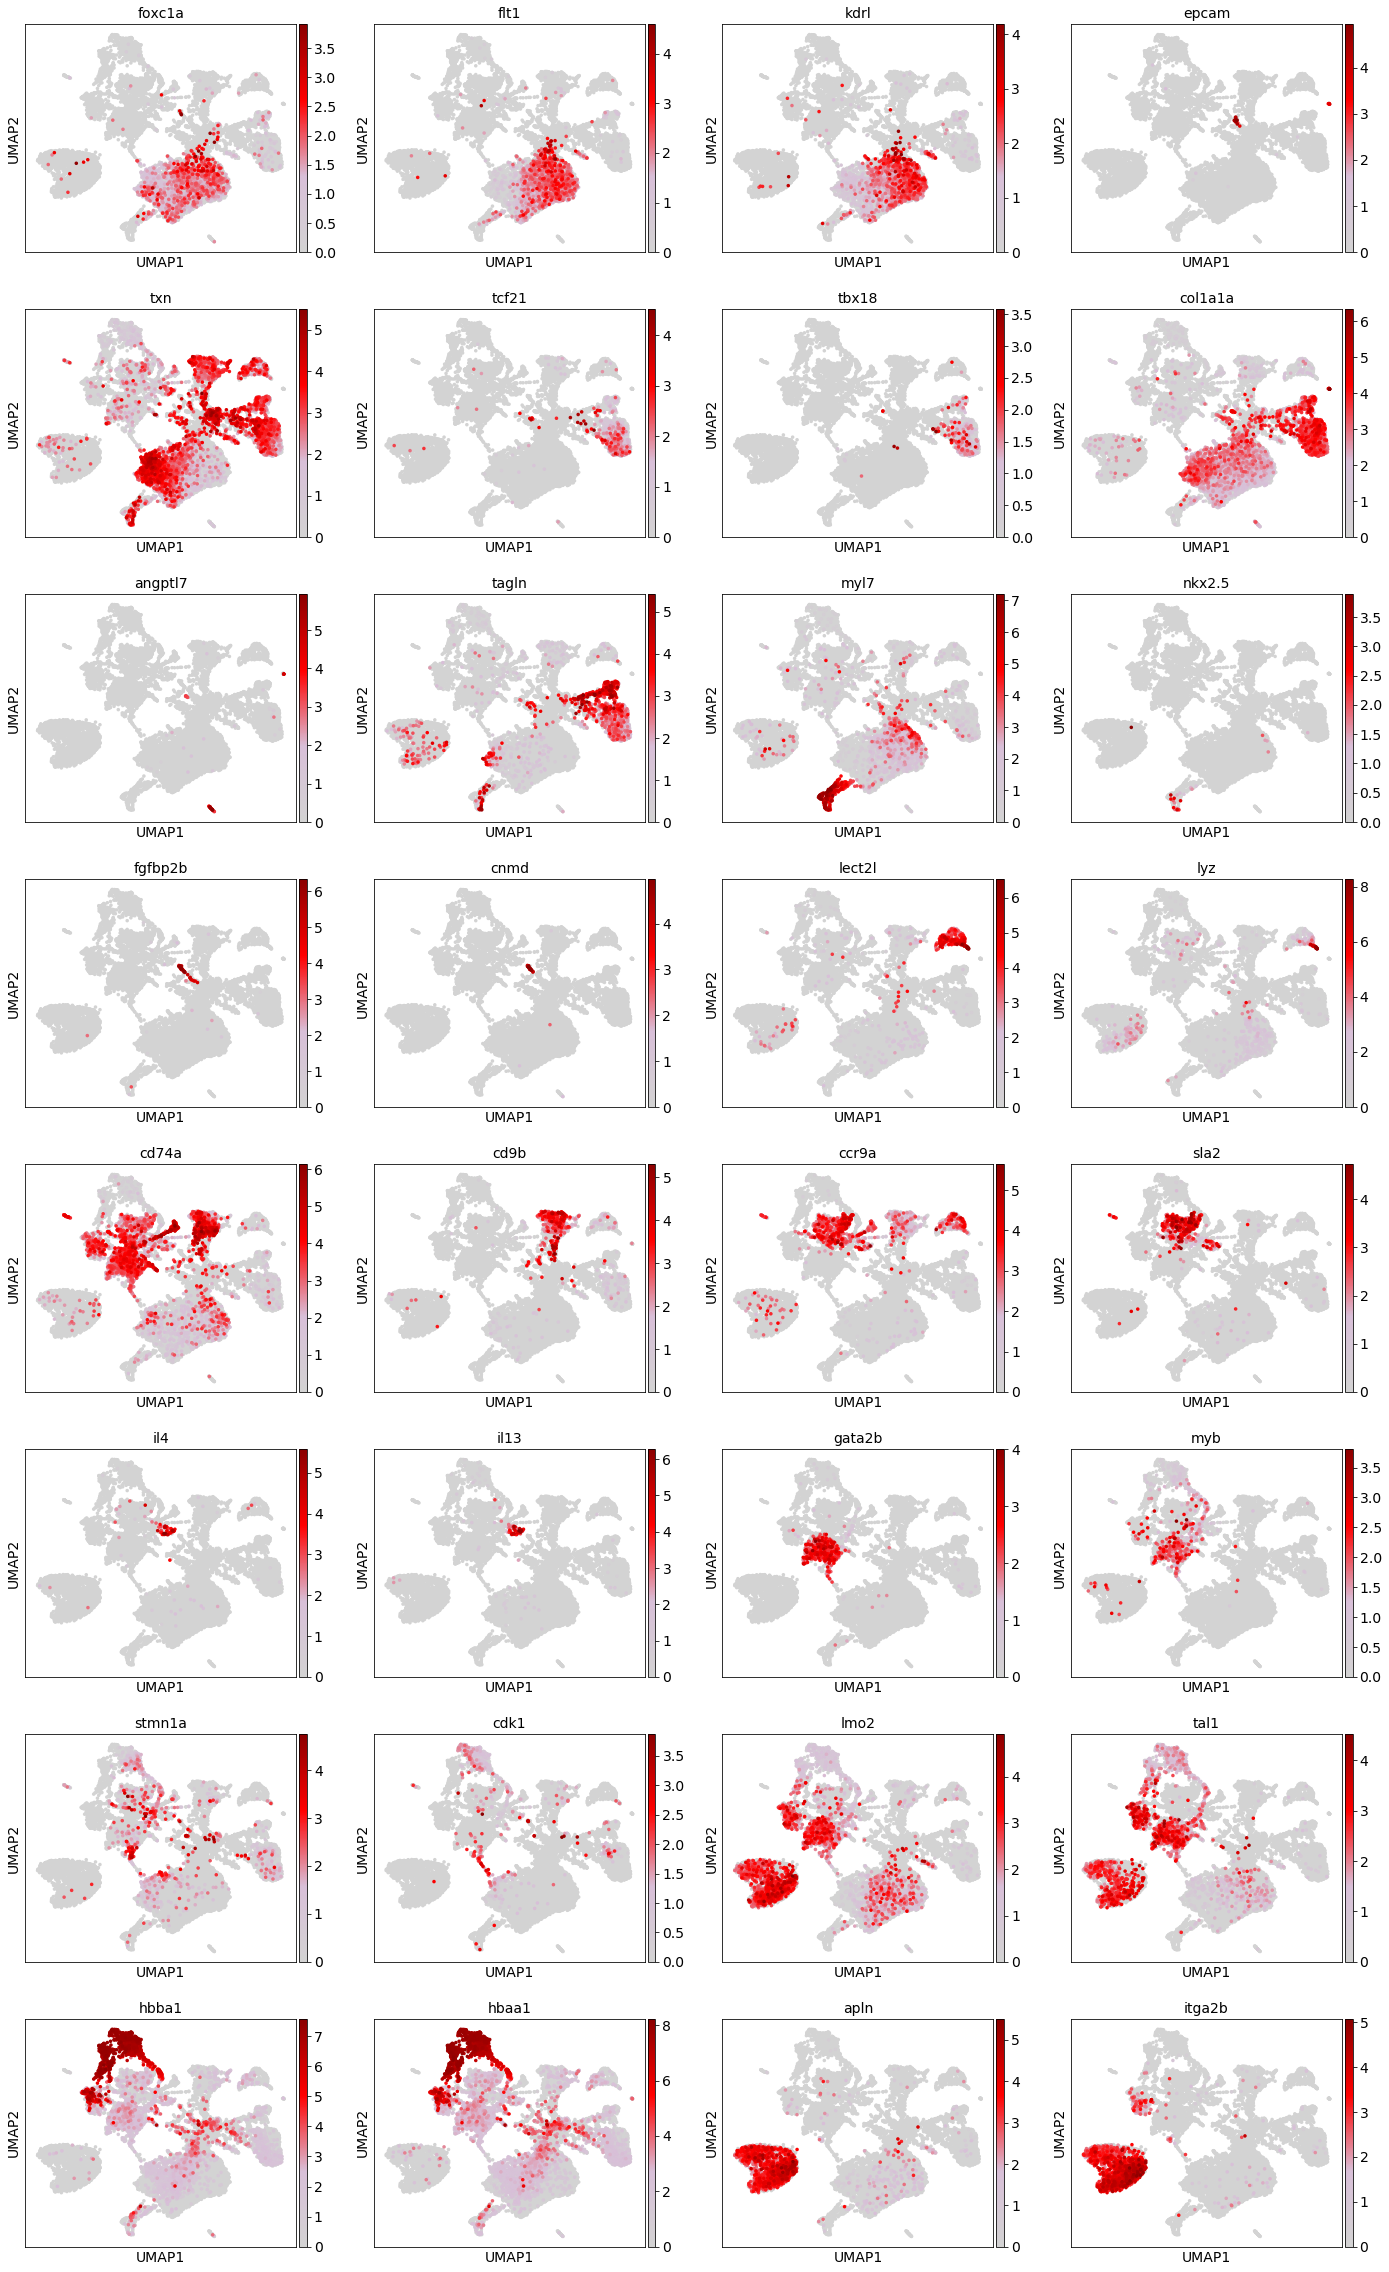

In [66]:
sc.pl.umap(adata, color=geneIDs, legend_loc="on data", size=50, color_map=cmap)

In [67]:
adata.write('/servers/lila-single-cell/Xiaonan/Zebrafish/New_Batch_Analysis_v2/write/Final_allcells_norm_afterQC.h5ad')